In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

In [2]:
# create original unit cell lattice vectors
a1 = (np.sqrt(3)/2, 0.5)
a2 = (-np.sqrt(3)/2, 0.5)
a3 = (0.0, -1.0)

# Create the original unit cell reciprocal Lattice
g1 = 2*np.pi/3*np.array([np.sqrt(3), 3.0])
g2 = 2*np.pi/3*np.array([-np.sqrt(3), 3.0])

# larger unit cell basis vectors (different gauge)
b1m = 3*a1
b2m = a2

#reciprocal lattice vectors of larger unit cell (different gauge)
h1m = g1/3
h2m = g2

In [3]:
# create momentum grid, spanned by vectors vec1 and vec2

def get_electron_mom_grid(L3, vec1, vec2):
    dg1 = vec1 / L3
    dg2 = vec2 / L3

    # range of indices, symmetric around zero
    idx = np.arange(-L3//2, L3//2)
    idy = np.arange(-L3//2, L3//2)

    EmomGrid = np.zeros((L3*L3, 2), dtype=float)
    EmomGridMat = np.zeros((L3, L3, 2), dtype=float)

    for i, n1 in enumerate(idx):
        for j, n2 in enumerate(idy):
            q_vec = n1 * dg1 + n2 * dg2
            EmomGrid[i*L + j] = q_vec
            EmomGridMat[i, j] = q_vec

    return EmomGrid, EmomGridMat

def get_mom_grid(L, vec1, vec2):
    """
    Build a 2D momentum grid centered around q = (0, 0)
    for a lattice with reciprocal vectors vec1, vec2.
    """
    dg1 = vec1 / L
    dg2 = vec2 / (3*L)

    # range of indices, symmetric around zero
    idx = np.arange(-L//2, L//2)
    idy = np.arange(-(3*L)//2, (3*L)//2)

    momGrid = np.zeros((3*L*L, 2), dtype=float)
    momGridMat = np.zeros((L, 3*L, 2), dtype=float)

    for i, n1 in enumerate(idx):
        for j, n2 in enumerate(idy):
            q_vec = n1 * dg1 + n2 * dg2
            momGrid[i*L + j] = q_vec
            momGridMat[i, j] = q_vec

    return momGrid, momGridMat

# Hamiltonian for the Partons
def Ham_Partons(k, vals, a1, a2, a3): #Bloch-Hamiltonian H(k) for partons, a1, a2, a3 are lattice vectors/ nearest neighbor
    t1, t2, t3, omg = vals
    ka1 = np.inner(k, a1)
    ka2 = np.inner(k, a2)
    ka3 = np.inner(k, a3)
    #np.inner computes the inner product of two arrays
    
    # nearest-neighbor hopping
    ek1 = np.exp(-1j*ka1)
    ek2 = np.exp(-1j*ka2)
    ek3 = np.exp(-1j*ka3)
    hk1 = t1*np.array([[ek2, np.exp(-1j*omg)*ek1, np.exp(1j*omg)*ek3],
                    [np.exp(-1j*omg)*ek3, np.exp(1j*omg)*ek2, ek1],
                    [np.exp(1j*omg)*ek1, ek3, np.exp(-1j*omg)*ek2]])

    return hk1 + np.conj(hk1.T)

# Get the eigenvalues and eigenvectors of the Hamiltonians with vals1 and vals2
def get_evals_evecs(L, vals, a1, a2, a3, h1m, h2m):

    kGrid, kGridMat = get_mom_grid(L, h1m, h2m)

    evals = np.full((L, 3*L, 3), None, dtype=float)
    evecs = np.full((L, 3*L, 3, 3), None, dtype=np.complex128)


    for kk in range(L):
        for pp in range(3*L):
            evals[kk, pp], evecs[kk, pp] = np.linalg.eigh(Ham_Partons(kGridMat[kk, pp], vals, a1, a2, a3))

    return evals, evecs

# get the Fermi energy
def get_energy(bands, dn=0, nu=1, nBands=3):
    ''' 
    bands_ has shape (L, 3*L, nBands)
    '''
    L = len(bands[:, 0, 0])         
    bands_new = np.reshape(bands, (nBands*3*L**2))
    bands_new = np.sort(bands_new)

    fillInt = int(nu*3*L**2+dn)
    energ = 1./(3*L**2) * np.sum(bands_new[:fillInt])
    return energ

#get the chemical potential
def get_chempot(bands, nu=1, nBands=3):
    L = len(bands[:, 0, 0]) 
    e1 = get_energy(bands, nu=nu, dn=1, nBands=nBands)*3*L**2
    em1 = get_energy(bands, nu=nu, dn=-1, nBands=nBands)*3*L**2
    return 0.5*(e1-em1)

print('everything works so far')

#convert the energy eigenenergies to ksi == E-mu
def get_ksi(bands, mu):
    L = len(bands[:, 0, 0])
    KSI = np.zeros((L, 3*L, 3), dtype=float)
    for kk in range(L):
        for pp in range(3*L):
            for band in range(3):
                KSI[kk, pp, band] = bands[kk, pp, band]-mu
    return KSI

everything works so far


In [4]:
#Define general parameters
L=10 #number of k-points in each direction

#Parameters for Partons with C= -1, -1, +2 (all 3 partons in nu=1/3, charge -e/3)
#take the values vals from Fabian's Code
vals1 = 1/9, 0.0, 0.0, 2*np.pi/3

#Parameters for Partons with C= -1, -1, +2 (1 parton species in nu=2/3 with charge -e/3)
#take the values vals from Fabian's Code
vals21 = 4/9, 0.0, 0.0, 2*np.pi/3

#Parameters for Partons with C= +2, -1, -1 (2 partons of parton species in nu=2/3, charge 2e/3)
#take the values vals from Fabian's Code
vals22 = -4/9, 0.0, 0.0, -2*np.pi/3

#get eigenvectors and eigenenergies/banddispersion
evals1, evecs1 = get_evals_evecs(L, vals1, a1, a2, a3, h1m, h2m)
evals21, evecs21 = get_evals_evecs(L, vals21, a1, a2, a3, h1m, h2m)
evals22, evecs22 = get_evals_evecs(L, vals22, a1, a2, a3, h1m, h2m)

#compute Fermi-energy and the chemical potential for nu=1/3 -> Partons have nu=1
E_F11 = get_energy(evals1, 0, 1, 3) 
mu_11 = get_chempot(evals1, 1, 3)

#compute Fermi-energy and the chemical potential for nu=2/3 -> Partons have nu=2
    #for charge -e/3 partons
E_F21 = get_energy(evals21, 0, 2, 3) 
mu_21 = get_chempot(evals21, 2, 3)
    #for charge 2e/3 partons
E_F22 = get_energy(evals22, 0, 2, 3) 
mu_22 = get_chempot(evals22, 2, 3)

#define Fermi-Dirac and Bose-Einstein summands


#create the grid spanned by h1m, h2m
kGrid, kGridMat = get_mom_grid(L, h1m, h2m)
kGrid_e, kGridMat_e = get_electron_mom_grid(3*L, g1, g2)

#get ksi = energy - chempot
ksi1 = get_ksi(evals1, mu_11)
ksi21 = get_ksi(evals21, mu_21)
ksi22 = get_ksi(evals22, mu_22)

In [5]:
def get_Zab(evecs):
    return np.einsum('kpal,kpbl->kpabl', np.conj(evecs), evecs)

def n_F(eps, beta):
    return 1/(np.exp(beta*eps)+1)

def get_Gp_ab_q_tau(evecs, bands, tau, beta):
    
    L = len(bands[:, 0, 0])
    N = len(tau)
    Gp_ab_q_tau = np.zeros((L, 3*L, 3, 3, N), dtype=np.complex128)
    for n, t in enumerate(tau):
        for kk in range(L):
            for pp in range(3*L):
                for a in range(3):
                    for b in range(3):
                        sum_ = 0
                        if t >= 0:
                            for m in range(3):
                                nF = n_F(bands[kk, pp, m], beta)
                                sum_ += evecs[kk, pp, a, m] * np.conj(evecs[kk, pp, b, m]) * np.exp(-bands[kk, pp, m]*t) * (nF-1)
                            Gp_ab_q_tau[kk, pp, a, b, n] = sum_
                        elif t < 0:
                            for m in range(3):
                                nF = n_F(bands[kk, pp, m], beta)
                                sum_ += evecs[kk, pp, a, m] * np.conj(evecs[kk, pp, b, m]) * np.exp(-bands[kk, pp, m]*t) * nF
                            Gp_ab_q_tau[kk, pp, a, b, n] = sum_ 
    return Gp_ab_q_tau

beta = 10.0
M = 1000
G_P1_q_POStau = get_Gp_ab_q_tau(evecs1, ksi1, np.linspace(0, beta, M), beta)
G_P21_q_POStau = get_Gp_ab_q_tau(evecs21, ksi21, np.linspace(0, beta, M), beta)
G_P22_q_POStau = get_Gp_ab_q_tau(evecs22, ksi22, np.linspace(0, beta, M), beta)
G_P1_q_BetaMintau = -G_P1_q_POStau[:, :, :, :, ::-1]
G_P21_q_BetaMintau = -G_P21_q_POStau[:, :, :, :, ::-1]
G_P22_q_BetaMintau = -G_P22_q_POStau[:, :, :, :, ::-1]

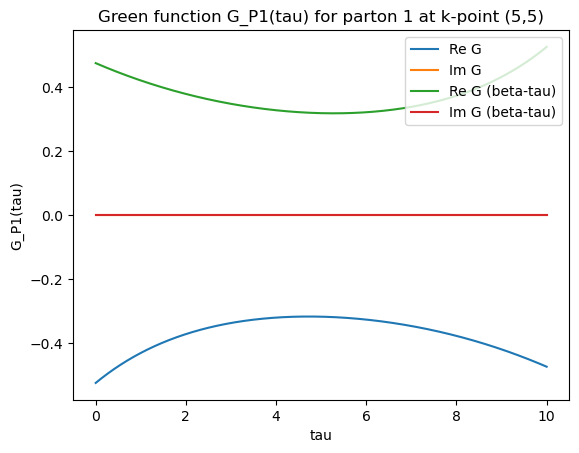

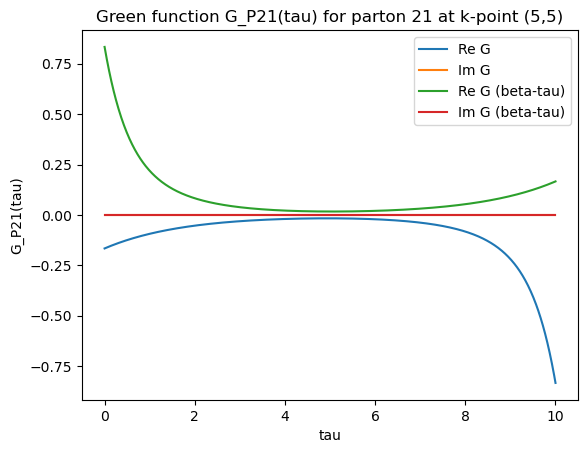

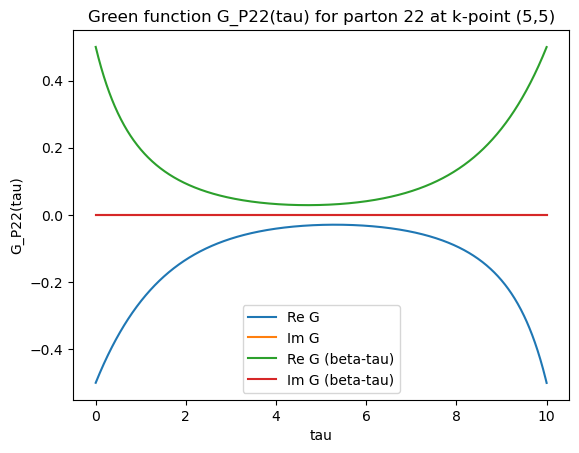

In [6]:
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, beta, M), np.real(G_P1_q_POStau[5, 5, 0, 0, :]), label='Re G')
plt.plot(np.linspace(0, beta, M), np.imag(G_P1_q_POStau[5, 5, 0, 0, :]), label='Im G')
plt.plot(np.linspace(0, beta, M), np.real(G_P1_q_BetaMintau[5, 5, 0, 0, :]), label='Re G (beta-tau)')
plt.plot(np.linspace(0, beta, M), np.imag(G_P1_q_BetaMintau[5, 5, 0, 0, :]), label='Im G (beta-tau)')
plt.xlabel('tau')
plt.ylabel('G_P1(tau)')
plt.title('Green function G_P1(tau) for parton 1 at k-point (5,5)')
plt.legend()
plt.show()
plt.plot(np.linspace(0, beta, M), np.real(G_P21_q_POStau[5, 5, 0, 0, :]), label='Re G')
plt.plot(np.linspace(0, beta, M), np.imag(G_P21_q_POStau[5, 5, 0, 0, :]), label='Im G')
plt.plot(np.linspace(0, beta, M), np.real(G_P21_q_BetaMintau[5, 5, 0, 0, :]), label='Re G (beta-tau)')
plt.plot(np.linspace(0, beta, M), np.imag(G_P21_q_BetaMintau[5, 5, 0, 0, :]), label='Im G (beta-tau)')
plt.xlabel('tau')
plt.ylabel('G_P21(tau)')
plt.title('Green function G_P21(tau) for parton 21 at k-point (5,5)')
plt.legend()
plt.show()
plt.plot(np.linspace(0, beta, M), np.real(G_P22_q_POStau[5, 5, 0, 0, :]), label='Re G')
plt.plot(np.linspace(0, beta, M), np.imag(G_P22_q_POStau[5, 5, 0, 0, :]), label='Im G')
plt.plot(np.linspace(0, beta, M), np.real(G_P22_q_BetaMintau[5, 5, 0, 0, :]), label='Re G (beta-tau)')
plt.plot(np.linspace(0, beta, M), np.imag(G_P22_q_BetaMintau[5, 5, 0, 0, :]), label='Im G (beta-tau)')
plt.xlabel('tau')
plt.ylabel('G_P22(tau)')
plt.title('Green function G_P22(tau) for parton 22 at k-point (5,5)')
plt.legend()
plt.show()

In [7]:
def get_C_mat_mat_vec(omg_mats, evecs, bands):
    """
    Vectorized version of get_C_mat_mat.

    Parameters
    ----------
    omg_mats : (N,) complex (or float) array
        Matsubara frequencies ω_n. If real, you can add a small +i*eta shift.
    evecs : (..., a, m) complex array
        Eigenvectors with indices (k, p, a, m) where a is orbital (size 3).
    bands : (k, p, m) real/complex array
        Band energies ε_{kpm}.
    eta : float, optional
        Small positive broadening; uses ω -> ω + i*eta.

    Returns
    -------
    C_mat : (k, p, a, b, N) complex array
        Orbital-resolved matrix for each (k,p) and ω_n:
        C^{ab}_{kp}(ω_n) = Σ_m Z^{ab}_{kpm} / (ω_n - ε_{kpm}),
        with Z^{ab}_{kpm} = evecs_{kpam} * evecs^*_{kpbm}.
    """
    # Projector weights Z_{k p a b m}
    Z_mat = np.einsum('kpam,kpbm->kpabm', evecs, np.conj(evecs))  # (k,p,3,3,m)

    # 1 / (ω_n - ε) for each (k,p,m,n)
    denom_inv = 1.0 / ( (omg_mats[None, None, None, :])  # (1,1,1,N)
                        - bands[..., None] )                      # (k,p,m,1)
    # Make shapes align to (k,p,m,N)
    denom_inv = denom_inv  # (k,p,m,N)

    # Sum over band index m:  (k,p,a,b,m) * (k,p,m,n) -> (k,p,a,b,n)
    C_mat = np.einsum('kpabm,kpmn->kpabn', Z_mat, denom_inv)

    return C_mat

beta = 50 #inverse temperature beta = 50
M = 1000 #number of negative Matsubara frequencies = number of positive Matsubara frequencies = M
omg_mats = 1j*np.pi*(2*np.arange(-M, M+1)+1)/ beta  #Matsubara frequencies, N=2*M+1

G_Parton1_iwn = get_C_mat_mat_vec(omg_mats, evecs1, ksi1) #nu = 1/3 parton with charge -e/3, 1 band filled with C=-1

G_Parton21_iwn = get_C_mat_mat_vec(omg_mats, evecs21, ksi21) #nu = 2/3 parton with charge -e/3, 2 bands filled C_ges = -1-1=-2
G_Parton22_iwn = get_C_mat_mat_vec(omg_mats, evecs22, ksi22) #nu = 2/3 2 partons with charge 2e/3, 2 bands filled C_ges = 2-1 =+1

In [8]:
#get G^i_ab(x,tau)
def get_G_ab_x_tau(G_ab_iwn_q):
    q_len = len(G_ab_iwn_q[:,0,0,0,0])
    l = len(G_ab_iwn_q[0,0,:,0,0])
    N = len(G_ab_iwn_q[0,0,0,0,:])
    G_x_tau = np.full((q_len, 3*q_len, l, l, N), None, dtype=complex)
    G_iwn_rev = G_ab_iwn_q[:, :, :, :, ::-1] # Reverse the Matsubara frequency order
    m  = np.arange(N)
    ferm_phase = np.exp(-1j * np.pi * (m / N))

    G_x_tau = np.sqrt(N)/beta * fft.ifftn(np.fft.ifftshift(G_iwn_rev, axes=(0, 1, 4)), axes=(0, 1, 4), norm='ortho')
    G_x_tau = G_x_tau * ferm_phase[None, None, None, None, :]
    
    return G_x_tau.astype(np.complex128)

def get_Chi0_ab_x_tau(G1_ab_x_tau, G2_ab_x_tau, G3_ab_x_tau, Fac1, Fac2, Fac3):
    L = len(G1_ab_x_tau[:,0,0,0,0])
    l = len(G1_ab_x_tau[0,0,:,0,0])
    N = len(G1_ab_x_tau[0,0,0,0,:])
    
    idx_minus_r = (-np.arange(L)) % L            # 0→0, 1→L-1, ...
    idy_minus_r = (-np.arange(3*L)) % (3*L)
    idab = np.arange(l)
    idx_beta_minus = (-np.arange(N)) % N      # 0→0, 1→N-1, ...
    G11 = G1_ab_x_tau
    G12 = -np.swapaxes(G1_ab_x_tau[np.ix_(idx_minus_r, idy_minus_r, idab, idab, idx_beta_minus)], 2, 3)
    G12[...,0] *= -1
    G21 = G2_ab_x_tau
    G22 = -np.swapaxes(G2_ab_x_tau[np.ix_(idx_minus_r, idy_minus_r, idab, idab, idx_beta_minus)], 2, 3)
    G22[...,0] *= -1
    G31 = G3_ab_x_tau
    G32 = -np.swapaxes(G3_ab_x_tau[np.ix_(idx_minus_r, idy_minus_r, idab, idab, idx_beta_minus)], 2, 3)
    G32[...,0] *= -1

    Chi0_ab_x_tau = 1/(3*L**2)*G11*G12*G21*G22*G31*G32+(3*L**2)*Fac2*Fac3*G11*G12+(3*L**2)*Fac1*Fac3*G21*G22+(3*L**2)*Fac1*Fac2*G31*G32-Fac1*G21*G22*G31*G32-Fac2*G11*G12*G31*G32-Fac3*G11*G12*G21*G22

    return 1/((3*L**2)**2)*Chi0_ab_x_tau 

def get_Chi0_ab_q_ivn(Chi0_ab_x_tau):
    N = len(Chi0_ab_x_tau[0,0,0,0,:])
    Chi0_ab_q_ivn_rev = fft.fftn(Chi0_ab_x_tau, axes=(0, 1, 4))
    Chi0_ab_q_ivn_rev = fft.fftshift(Chi0_ab_q_ivn_rev, axes=(0, 1, 4))
    Chi0_ab_q_ivn = Chi0_ab_q_ivn_rev[:, :, :, :, ::-1] # Reverse the Matsubara frequency order

    # Include β for the τ integral (since τ grid is mβ/N and NumPy's FFT is a plain sum)
    Chi0_ab_q_ivn *= beta/N
 
    return Chi0_ab_q_ivn

def get_ChiRPA_ab(Chi0_ab_q_ivn, V_q):
    L = len(Chi0_ab_q_ivn[:,0,0,0,0])
    N = len(Chi0_ab_q_ivn[0,0,0,0,:])
    l = len(Chi0_ab_q_ivn[0,0,:,0,0])
    ChiRPA_ab_q_v = np.full((L, 3*L, l, l, N), None, dtype=complex)
    I = np.identity(3)
    for qq in range(L):
        for pp in range(3*L):
            for n in range(N):
                A = I - Chi0_ab_q_ivn[qq, pp, :, :, n]*V_q[qq, pp, :, :]
                B = Chi0_ab_q_ivn[qq, pp, :, :, n]
                if np.linalg.det(A) != 0:
                    ChiRPA_ab_q_v[qq, pp, :, :, n] = -np.linalg.inv(A)*B
                else:
                    print(f"Matrix is singular at q=({qq},{pp}), n={n}. Setting Chi_RPA to zero.")
                    ChiRPA_ab_q_v[qq, pp, :, :, n] = 0   
    return ChiRPA_ab_q_v

def get_ChiRPA_x_v(ChiRPA_ab_q_v):
    N = len(ChiRPA_ab_q_v[0,0,0,0,:])
    ChiRPA_ab_x_v = fft.ifftn(ChiRPA_ab_q_v, axes=(0, 1))
    ChiRPA_ab_x_v = ChiRPA_ab_x_v.astype(np.complex128)
    return ChiRPA_ab_x_v

def get_ChiRPA_r_v(ChiRPA_ab_x_v):
    L = len(ChiRPA_ab_x_v[:,0,0,0,0])
    l = len(ChiRPA_ab_x_v[0,0,:,0,0])
    N = len(ChiRPA_ab_x_v[0,0,0,0,:])
    ChiRPA_r_v = np.zeros((3*L,3*L,N))
    for xx in range(L):
        for yy in range(3*L):
            for a in range(l):
                ChiRPA_r_v[3*xx+a,yy,:] = ChiRPA_ab_x_v[xx,yy,a,0,:]
    return ChiRPA_r_v

def get_ChiRPA_k_v(ChiRPA_r_tau):
    N = len(ChiRPA_r_tau[0,0,:])
    ChiRPA_k_v_rev = fft.fftn(ChiRPA_r_tau, axes=(0, 1))
    ChiRPA_k_v = fft.fftshift(ChiRPA_k_v_rev, axes=(0, 1))
    ChiRPA_k_v = ChiRPA_k_v.astype(np.complex128)
    return ChiRPA_k_v

def get_V_NN_q_TILDE(qGridMat, V):
    L = len(qGridMat[:,0])
    V_q = np.full((L, 3*L, 3, 3), None, dtype=float)
    for qq in range(L):
        for pp in range(3*L):
            V_q[qq,pp, :, :] = [[2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), np.exp(-1j*2*np.pi*(qq-L//2)/L)*(V+V*np.exp(1j*2*np.pi*(qq+pp-L//2-(3*L)//2)/(3*L))), V*np.exp(-1j*6*np.pi*(qq-L//2)/L)*(1+np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)))], [np.exp(1j*2*np.pi*(qq-L//2)/L)*V+V*np.exp(1j*2*np.pi*(qq-L//2)/L)*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), np.exp(-1j*2*np.pi*(qq-L//2)/L)*V+V*np.exp(-1j*2*np.pi*(qq-L//2)/L)*np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))], [V*np.exp(1j*6*np.pi*(qq-L//2)/L)*(1+np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))), np.exp(1j*2*np.pi*(qq-L//2)/L)*V+np.exp(1j*2*np.pi*(qq-L//2)/L)*V*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L))]]
    return V_q

def get_V_NN_q(qGridMat, V):
    L = len(qGridMat[:,0])
    V_q = np.full((L, 3*L, 3, 3), None, dtype=float)
    for qq in range(L):
        for pp in range(3*L):
            V_q[qq,pp, :, :] = [[2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), (V+V*np.exp(1j*2*np.pi*(qq+pp-L//2-(3*L)//2)/(3*L))), V*np.exp(-1j*2*np.pi*(qq-L//2)/L)*(1+np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)))], [V+V*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), V+V*np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))], [V*np.exp(1j*2*np.pi*(qq-L//2)/L)*(1+np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))), V+V*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L))]]
    return V_q

In [9]:

V_NN1 = get_V_NN_q(kGridMat, 3.0) #NN interaction in momentum space with strength V=1.0
V_NN2 = get_V_NN_q(kGridMat, 1.5) #NN interaction in momentum space with strength V=1.0
V_NN1_TILDE = get_V_NN_q_TILDE(kGridMat, 3.0) #NN interaction in momentum space with strength V=1.0
V_NN2_TILDE = get_V_NN_q_TILDE(kGridMat, 1.5) #NN interaction in momentum space with strength V=1.0

Fac11 = 1/9
Fac21 = 4/9
Fac22 = 4/9

/tmp/ipykernel_169557/2701729833.py:105: ComplexWarning: Casting complex values to real discards the imaginary part
  V_q[qq,pp, :, :] = [[2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), (V+V*np.exp(1j*2*np.pi*(qq+pp-L//2-(3*L)//2)/(3*L))), V*np.exp(-1j*2*np.pi*(qq-L//2)/L)*(1+np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)))], [V+V*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), V+V*np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))], [V*np.exp(1j*2*np.pi*(qq-L//2)/L)*(1+np.exp(1j*2*np.pi*(pp-(3*L)//2)/(3*L))), V+V*np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)), 2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L))]]
/tmp/ipykernel_169557/2701729833.py:97: ComplexWarning: Casting complex values to real discards the imaginary part
  V_q[qq,pp, :, :] = [[2*V*np.cos(2*np.pi*(pp-(3*L)//2)/(3*L)), np.exp(-1j*2*np.pi*(qq-L//2)/L)*(V+V*np.exp(1j*2*np.pi*(qq+pp-L//2-(3*L)//2)/(3*L))), V*np.exp(-1j*6*np.pi*(qq-L//2)/L)*(1+np.exp(-1j*2*np.pi*(pp-(3*L)//2)/(3*L)))], [np.exp(1j*2*np.pi*(qq-L//2)/L)*V+V*np.exp(1

In [10]:
def get_Zaa(evecs):
    return np.einsum('kpal,kpal->kpal', np.conj(evecs), evecs)

def get_1stSumFac(Zaa, nF_ksi):
    L = len(nF_ksi[:,0,0])
    return 1/(3*L*L)*np.einsum('kpal, kpl->a', Zaa, nF_ksi)

Z1aa = get_Zaa(evecs1)
nF_ksi1 = n_F(ksi1, beta)

Z21aa = get_Zaa(evecs21)
nF_ksi21 = n_F(ksi21, beta)

Z22aa = get_Zaa(evecs22)
nF_ksi22 = n_F(ksi22, beta)

sumFac11 = get_1stSumFac(Z1aa, nF_ksi1)
sumFac21 = get_1stSumFac(Z21aa, nF_ksi21)
sumFac22 = get_1stSumFac(Z22aa, nF_ksi22)
Fac11_ = np.multiply.outer(sumFac11, sumFac11)
Fac21_ = np.multiply.outer(sumFac21, sumFac21)
Fac22_ = np.multiply.outer(sumFac22, sumFac22)
Fac11 = 1/9
Fac21 = 4/9
Fac22 = 4/9

In [11]:
def get_Xmat(G_iwn, iWn):
    G_iwn = np.asarray(G_iwn, dtype=np.complex128)   # preserve complex
    iWn   = np.asarray(iWn,   dtype=np.complex128)

    L, L, N  = G_iwn.shape
    half  = N // 2
    X     = np.ones((L, L, N, N), dtype=np.complex128)
    SIGMA = np.empty((L, L, N),   dtype=np.complex128)

    # Precompute powers: P[i, j] = (iWn[i])**j
    P = np.power.outer(iWn, np.arange(N, dtype=int))   # shape (N, N)

    exp_sigma = (N - 1) // 2 + 1                       # integer exponent
    for pp in range(L):
        for qq in range(L):
            SIGMA[pp, qq, :]      = G_iwn[pp, qq, :] * P[:, exp_sigma]    # once per qq
            X[pp, qq, :, 1:half]  = P[:, 1:half]                      # cols 1..half-1
            X[pp, qq, :, half:]   = -G_iwn[pp, qq, :, None] * P[:, :N-half]  # cols half..N-1

    return X, SIGMA

def get_pqList(X, SIGMA):
    L, L, N = SIGMA.shape
    pq_list = np.ones((L, L, N), dtype=np.complex128)
    for pp in range(L):
        for qq in range(L):
            pq_list[pp, qq] = np.linalg.solve(X[pp, qq], SIGMA[pp, qq])
    return pq_list

def pade_rational_monic(z, pq, r):
    """
    R(z) = (a0 + a1 z + ... + a_{r-2} z^{r-2}) /
           (z^r + b_{r-1} z^{r-1} + ... + b_1 z + b_0)

    pq layout (length 2r-1): [a0, ..., a_{r-2},  b0, b1, ..., b_{r-1}]
    """
    pq = np.asarray(pq, dtype=np.complex128)
    expect = 2*r - 1
    if pq.size != expect:
        raise ValueError(f"pq must have length {expect} for monic case; got {pq.size}.")
    if r < 2:
        raise ValueError("r must be ≥ 2 (otherwise numerator degree r-2 is invalid).")

    n_coeff = r - 1
    a = pq[:n_coeff]            # a0..a_{r-2}
    b = pq[n_coeff:]            # b0..b_{r-1}

    z = np.asarray(z, dtype=np.complex128)

    # Horner numerator
    num = np.zeros_like(z, dtype=np.complex128)
    for c in a[::-1]:
        num = num*z + c

    # Denominator: z^r + b_{r-1} z^{r-1} + ... + b_0
    den = np.ones_like(z, dtype=np.complex128)  # builds leading z^r
    for c in b[::-1]:
        den = den*z + c

    return num / den

def get_PADE3(OMEGA_real, pq_list, r): #2r-1=M, num deg = r-2, denom deg = r
    L, L, N = pq_list.shape
    PADE_chi_0 = np.ones((L, L, 300), dtype=np.complex128)
    for pp in range(L):
        for qq in range(L):
            PADE_chi_0[pp, qq] = pade_rational_monic(OMEGA_real, pq_list[pp, qq], r)
    return PADE_chi_0

In [12]:
Pade_omg_mats = 1j*2*np.pi*np.arange(0, 402, 2)/ beta
OMEGA_real1 = np.linspace(0, 3, 300)+1j*1e-2*np.ones(300) #real frequencies + small imaginary part
OMEGA_real2 = np.linspace(0, 6, 300)+1j*1e-2*np.ones(300) #real frequencies + small imaginary part

def get_ChiRPA_all(G1iwn, G2iwn, G3iwn, Fac1, Fac2, Fac3, V, PadeOMGmats, omega_real, Vscale=9, r=101):
    G1_x_tau = get_G_ab_x_tau(G1iwn)
    G2_x_tau = get_G_ab_x_tau(G2iwn)
    G3_x_tau = get_G_ab_x_tau(G3iwn)
    Chi0_ab_x_tau = get_Chi0_ab_x_tau(G1_x_tau, G2_x_tau, G3_x_tau, Fac1, Fac2, Fac3)
    Chi0_ab_q_ivn = get_Chi0_ab_q_ivn(Chi0_ab_x_tau)
    ChiRPA_list = []
    for a in range(1, Vscale+1):
        ChiRPA_ab_q_ivn = get_ChiRPA_ab(Chi0_ab_q_ivn, 0.2*a*V)
        ChiRPA_ab_x_ivn = get_ChiRPA_x_v(ChiRPA_ab_q_ivn)
        ChiRPA_r_ivn = get_ChiRPA_r_v(ChiRPA_ab_x_ivn)
        ChiRPA_k_ivn = get_ChiRPA_k_v(ChiRPA_r_ivn)
        X_ChiRPA, SIGMA_ChiRPA = get_Xmat(ChiRPA_k_ivn[:,:,M:M+402:2], PadeOMGmats)
        pq_list_ChiRPA = get_pqList(X_ChiRPA, SIGMA_ChiRPA)
        PADE_ChiRPA = get_PADE3(omega_real, pq_list_ChiRPA, r)
        ChiRPA_list.append(PADE_ChiRPA)
    return ChiRPA_list

Chi1RPA_list = get_ChiRPA_all(G_Parton1_iwn, G_Parton1_iwn, G_Parton1_iwn, Fac11, Fac11, Fac11, V_NN1, Pade_omg_mats, OMEGA_real1)
Chi2RPA_list = get_ChiRPA_all(G_Parton21_iwn, G_Parton22_iwn, G_Parton22_iwn, Fac21, Fac22, Fac22, V_NN2, Pade_omg_mats, OMEGA_real2)

/tmp/ipykernel_169557/2701729833.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  ChiRPA_r_v[3*xx+a,yy,:] = ChiRPA_ab_x_v[xx,yy,a,0,:]
/tmp/ipykernel_169557/2607601857.py:11: RuntimeWarning: overflow encountered in power
  P = np.power.outer(iWn, np.arange(N, dtype=int))   # shape (N, N)


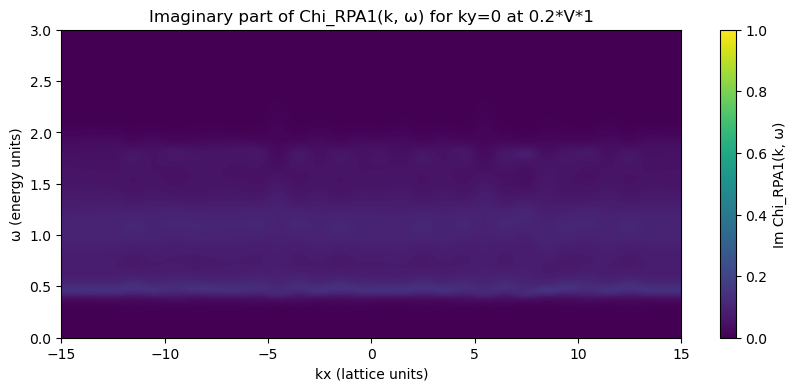

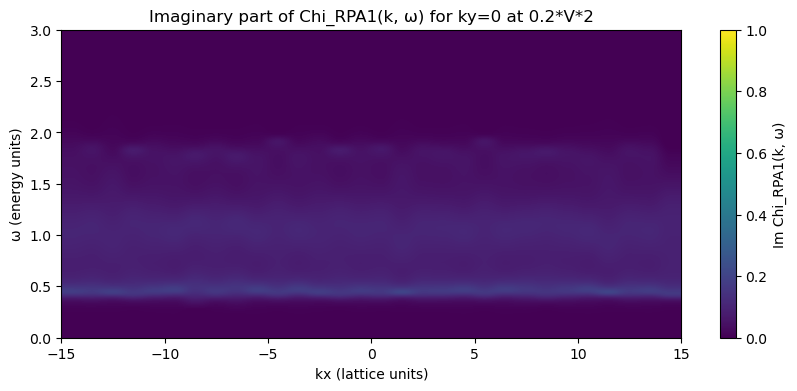

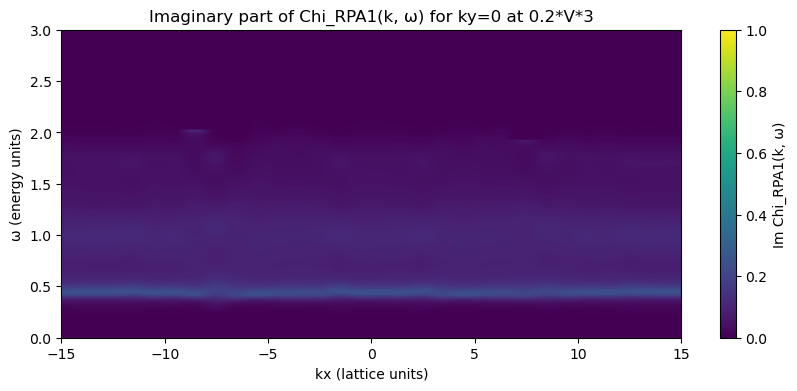

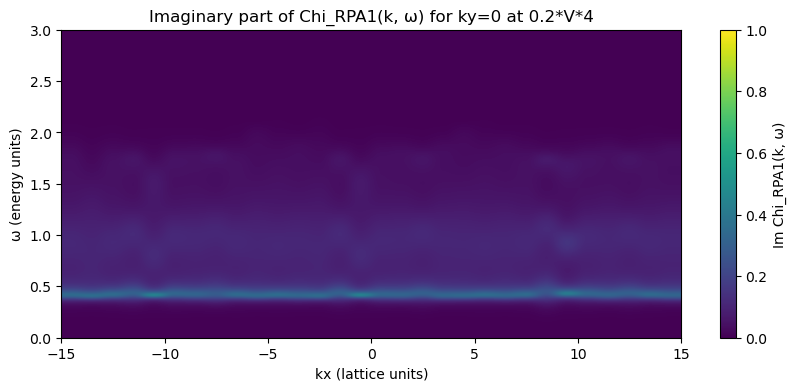

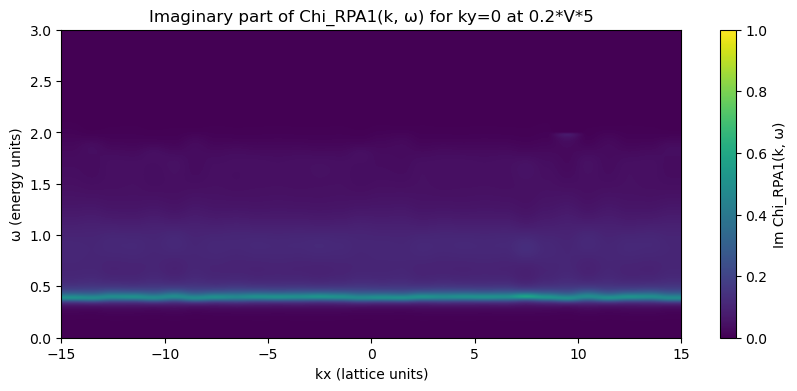

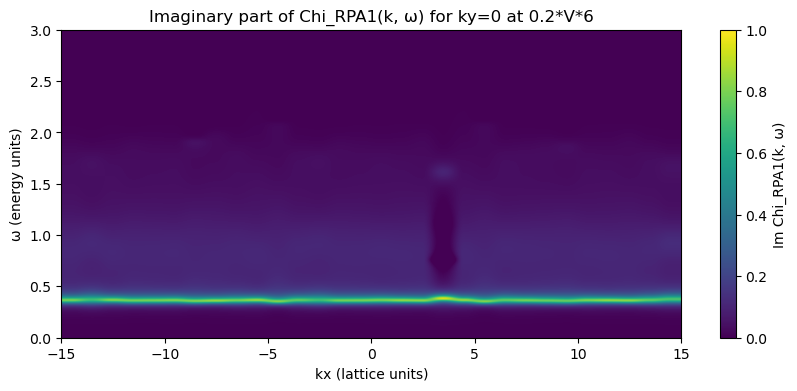

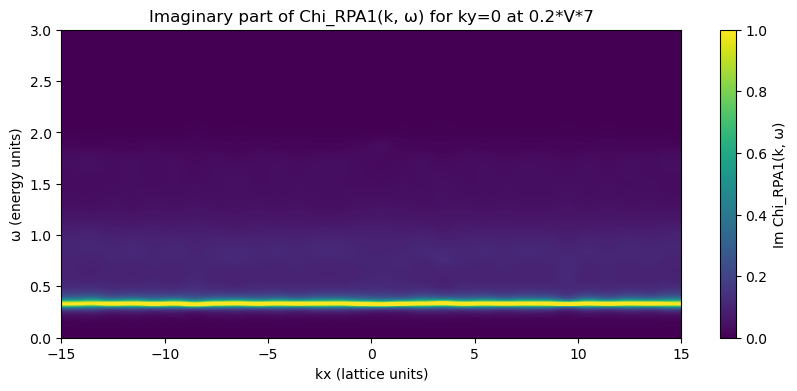

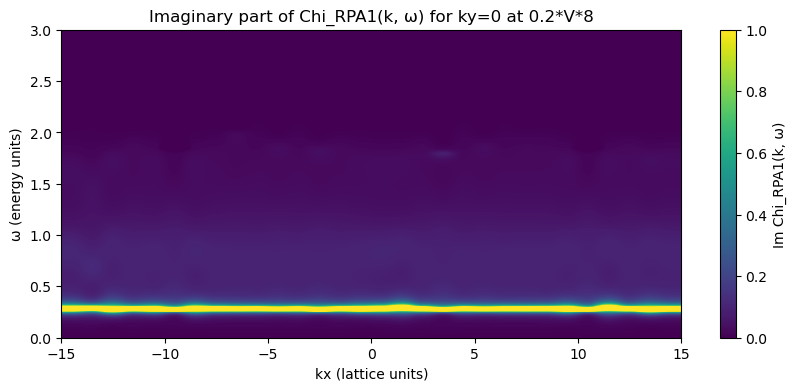

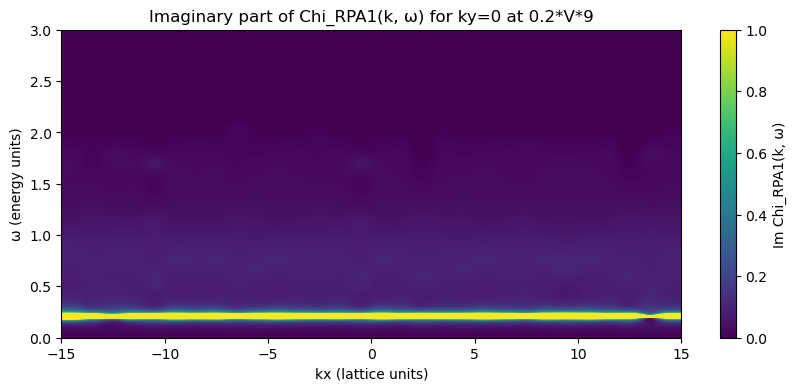

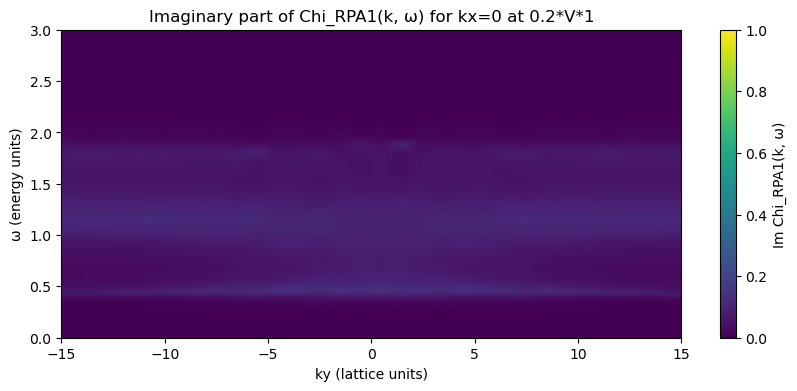

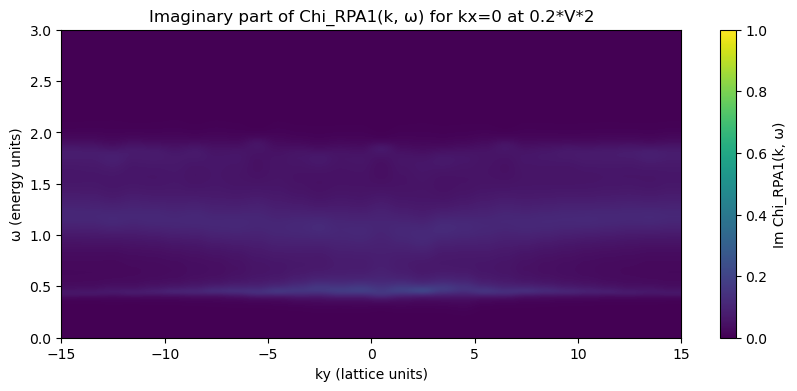

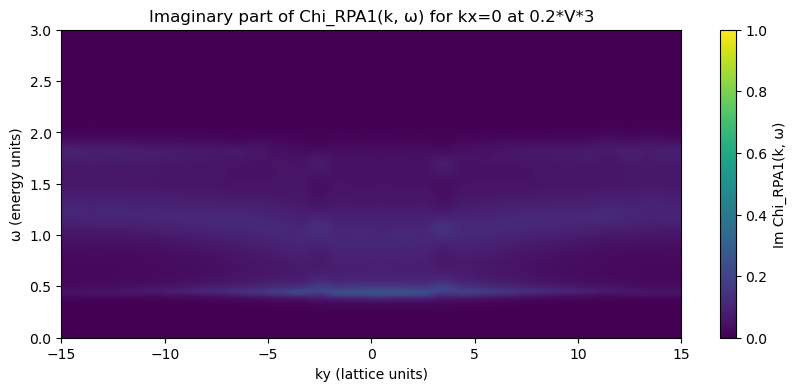

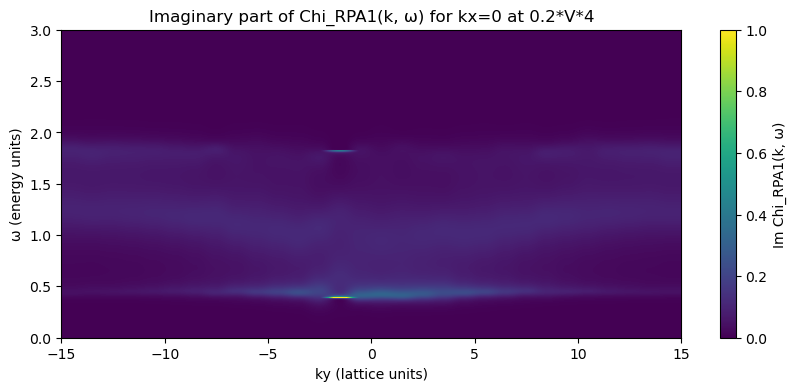

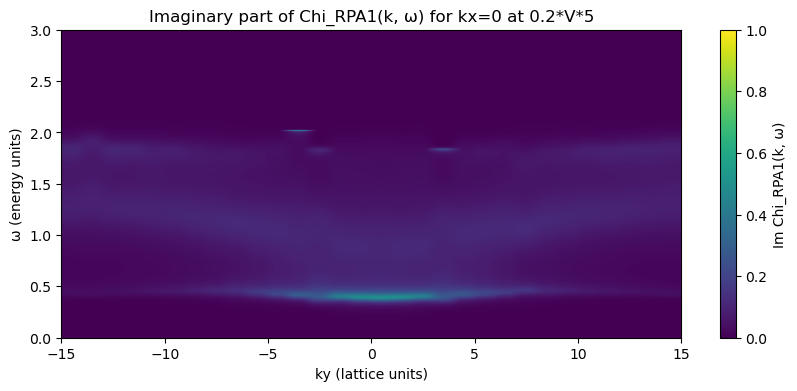

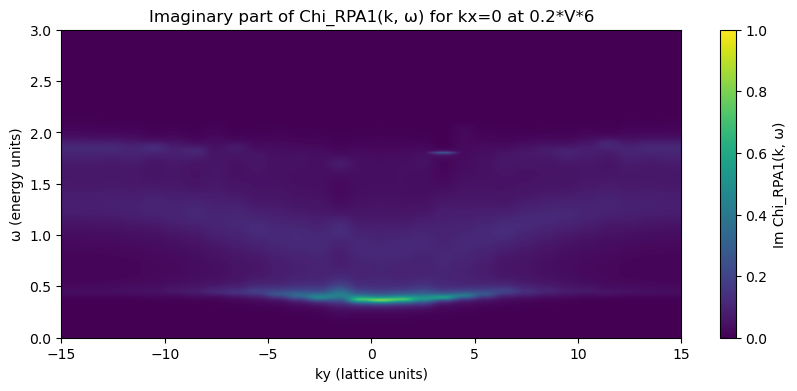

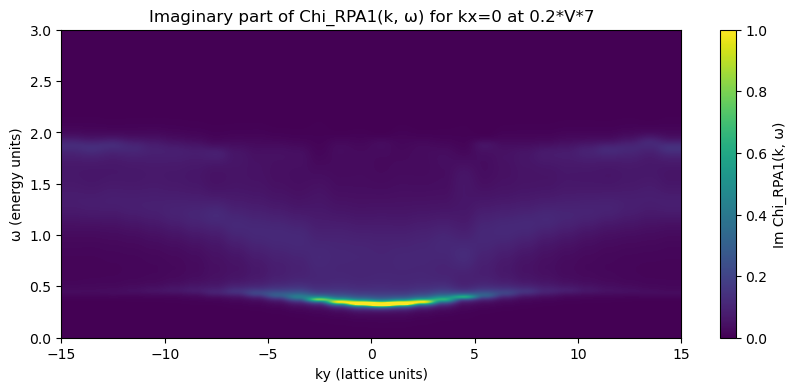

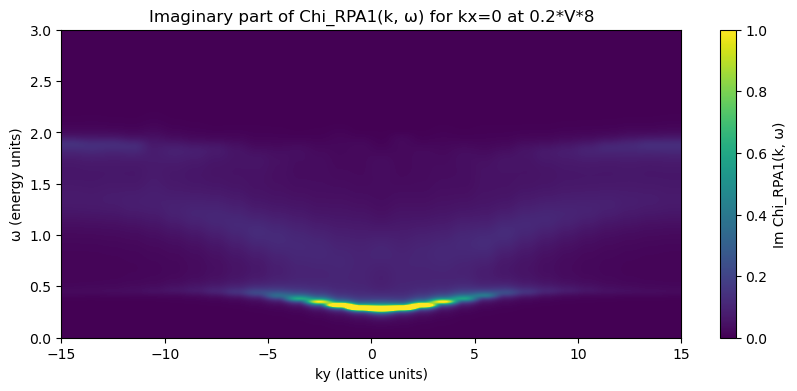

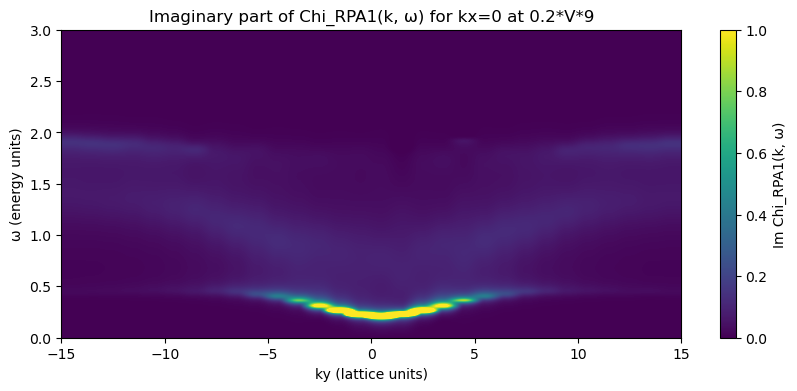

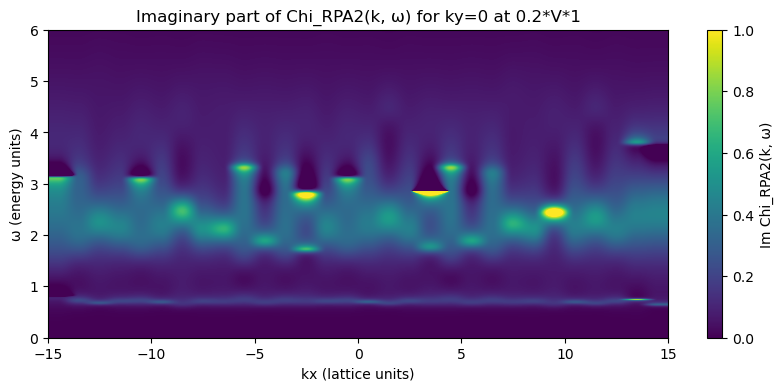

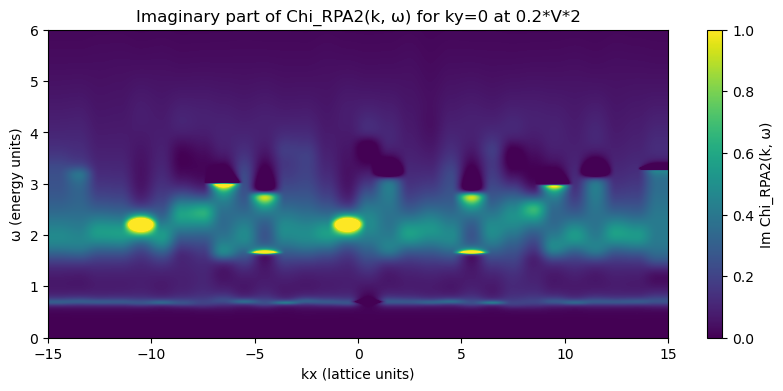

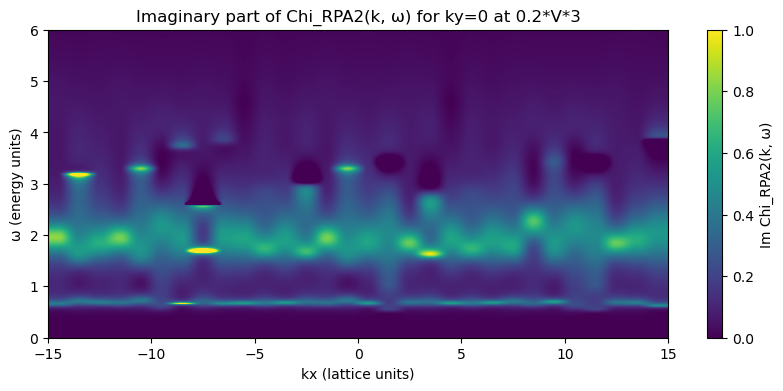

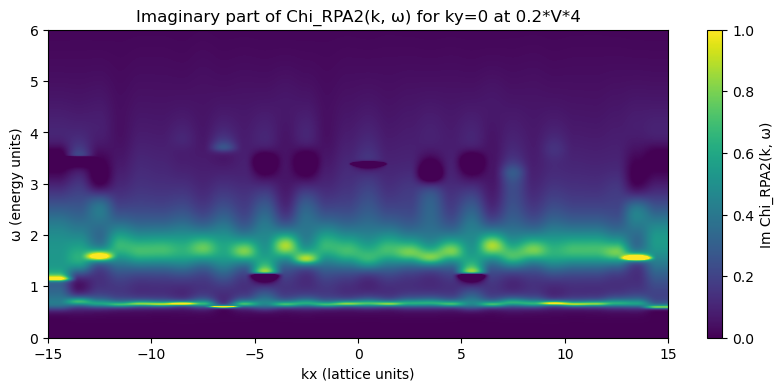

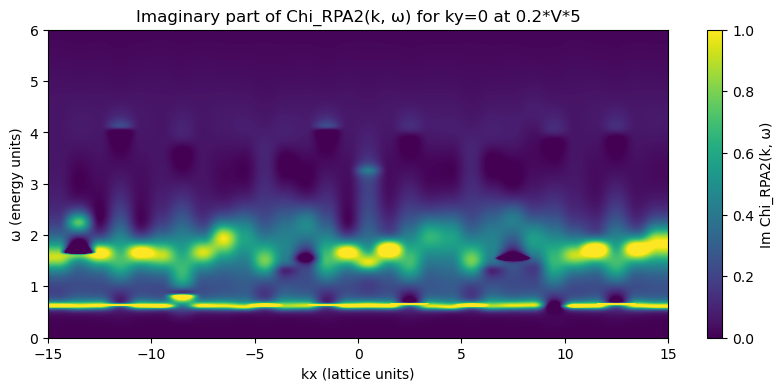

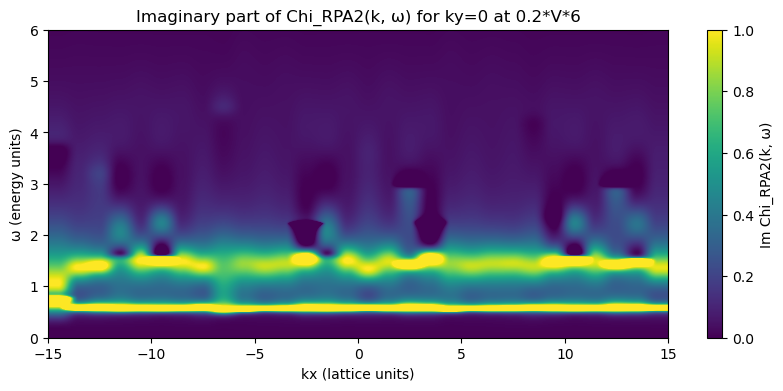

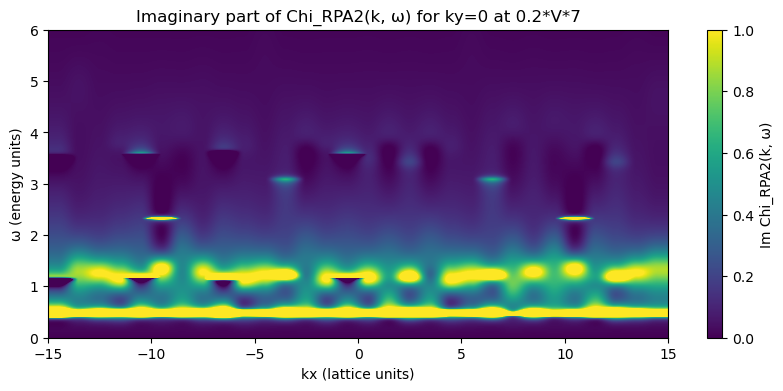

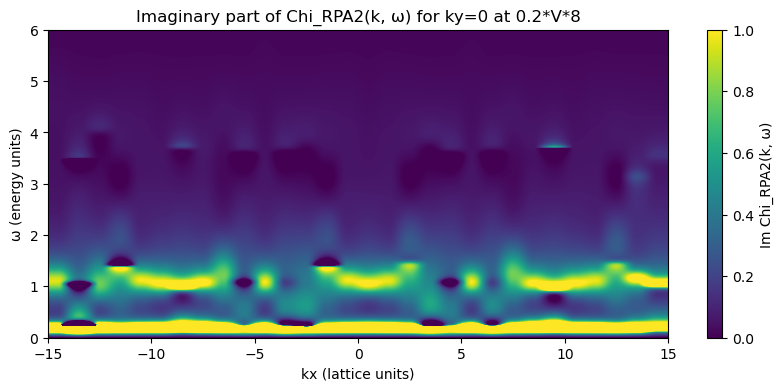

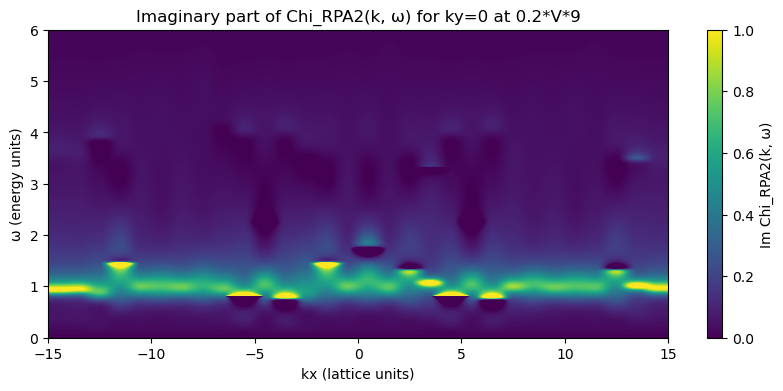

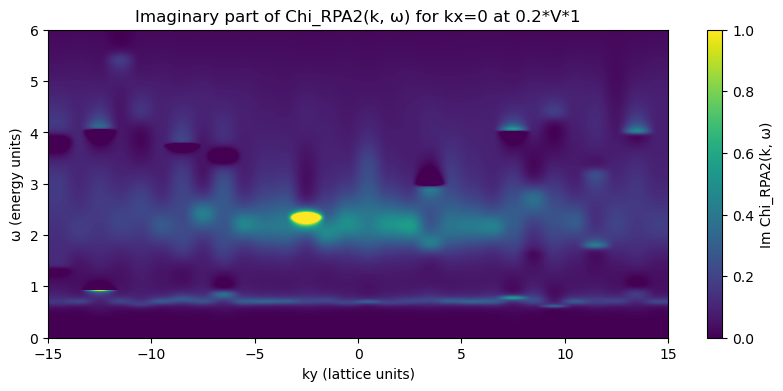

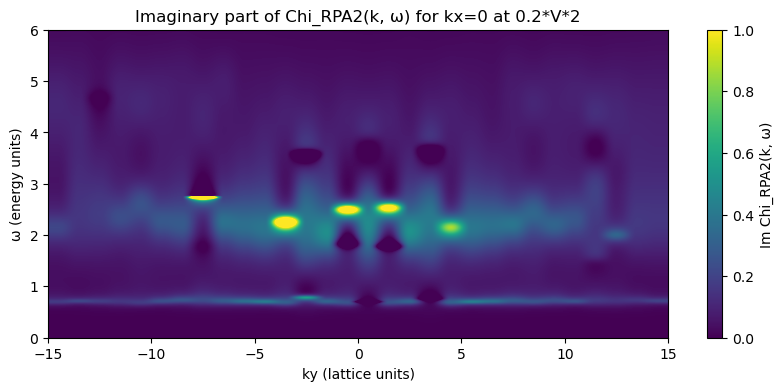

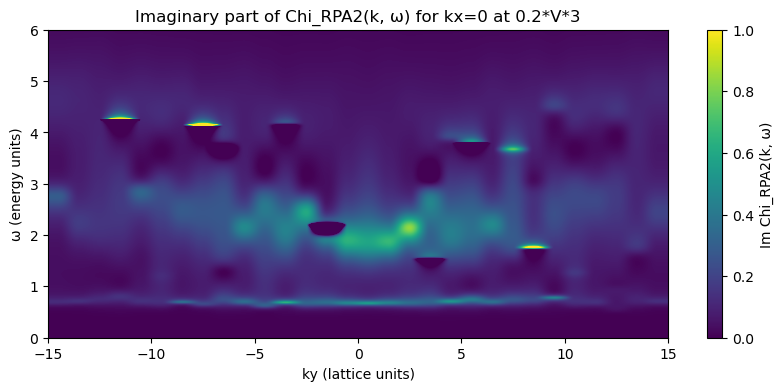

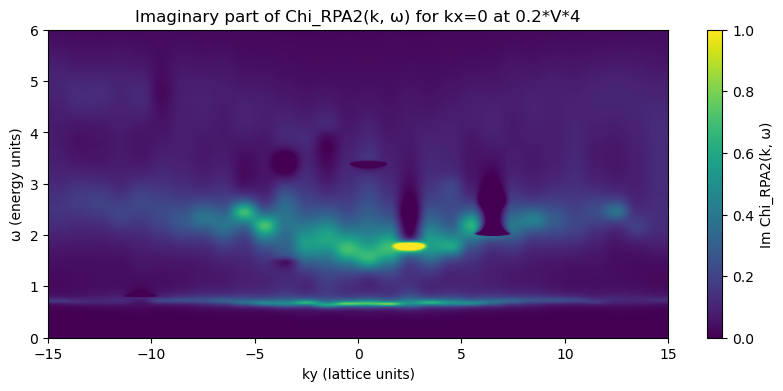

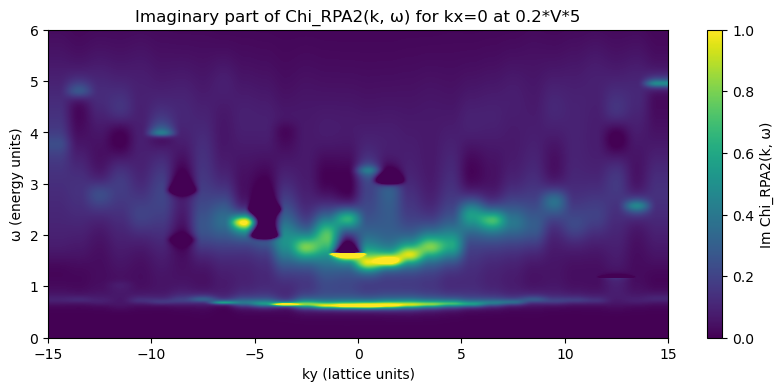

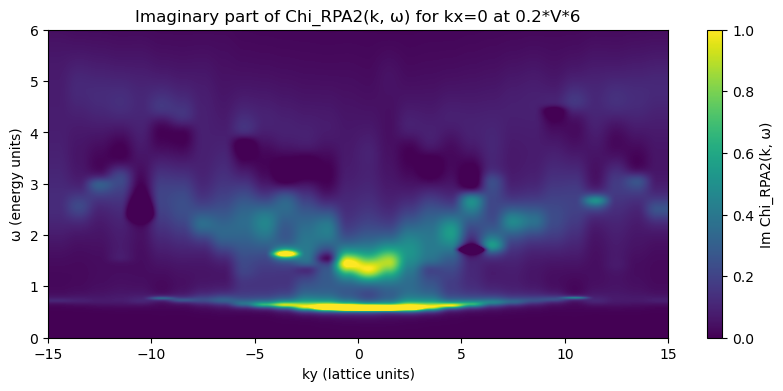

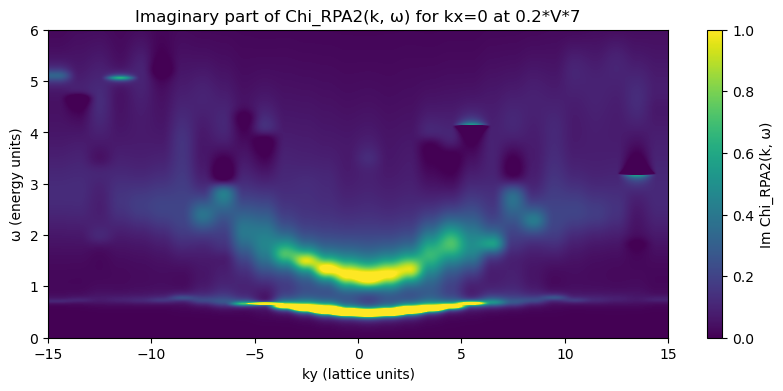

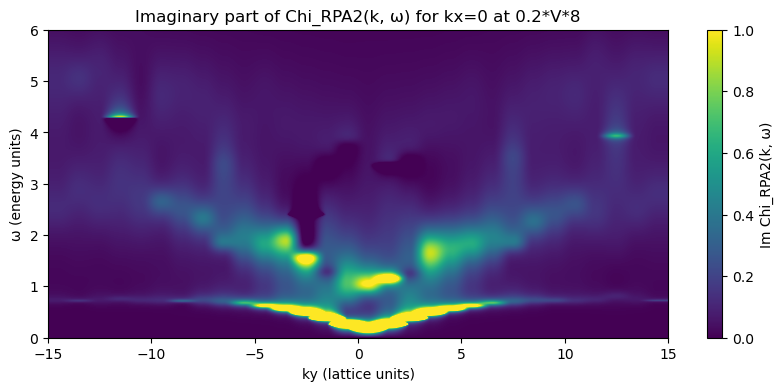

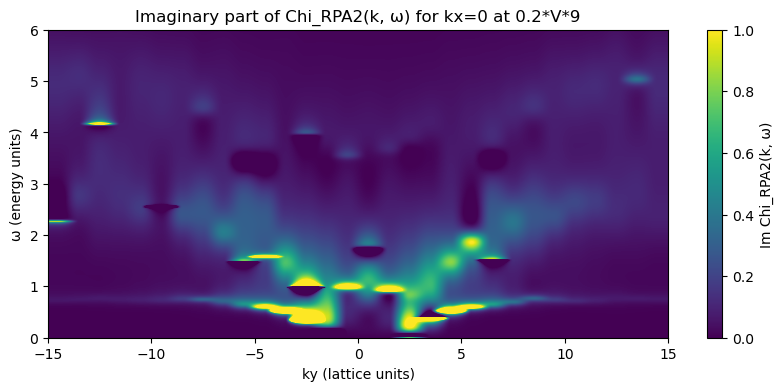

In [13]:
for n, a in enumerate(Chi1RPA_list):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(np.imag(a[:, (3*L)//2, :])), extent=(-(3*L)//2, (3*L)//2, 0, 3), origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=1.0)
    plt.colorbar(label='Im Chi_RPA1(k, ω)')
    plt.xlabel('kx (lattice units)')
    plt.ylabel('ω (energy units)')
    plt.title('Imaginary part of Chi_RPA1(k, ω) for ky=0 at 0.2*V*'+str(n+1))
    plt.show()

for n, a in enumerate(Chi1RPA_list):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(np.imag(a[(3*L)//2, :, :])), extent=(-(3*L)//2, (3*L)//2, 0, 3), origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=1.0)
    plt.colorbar(label='Im Chi_RPA1(k, ω)')
    plt.xlabel('ky (lattice units)')
    plt.ylabel('ω (energy units)')
    plt.title('Imaginary part of Chi_RPA1(k, ω) for kx=0 at 0.2*V*'+str(n+1))
    plt.show()

for n, a in enumerate(Chi2RPA_list):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(np.imag(a[:, (3*L)//2, :])), extent=(-(3*L)//2, (3*L)//2, 0, 6), origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=1.0)
    plt.colorbar(label='Im Chi_RPA2(k, ω)')
    plt.xlabel('kx (lattice units)')
    plt.ylabel('ω (energy units)')
    plt.title('Imaginary part of Chi_RPA2(k, ω) for ky=0 at 0.2*V*'+str(n+1))
    plt.show()

for n, a in enumerate(Chi2RPA_list):
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(np.imag(a[(3*L)//2, :, :])), extent=(-(3*L)//2, (3*L)//2, 0, 6), origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=1.0)
    plt.colorbar(label='Im Chi_RPA2(k, ω)')
    plt.xlabel('ky (lattice units)')
    plt.ylabel('ω (energy units)')
    plt.title('Imaginary part of Chi_RPA2(k, ω) for kx=0 at 0.2*V*'+str(n+1))
    plt.show()
